### Import libraries, define directiories

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd
import platform
import time

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

# MobileNet
from keras.applications.mobilenet_v3 import decode_predictions

# WordVec
import gensim.downloader
import wordninja

import time


2024-08-23 17:26:10.356707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Directories

In [6]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/human_pose
data directory is /Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition


In [58]:
from PIL import Image
import os

def compute_average_image_size_and_weight(folder_path):
    # Initialize variables to store total dimensions and file size
    total_width = 0
    total_height = 0
    total_weight = 0
    image_count = 0
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):  # Add more image formats if needed
            image_path = os.path.join(folder_path, filename)
            
            # Open the image file
            with Image.open(image_path) as img:
                width, height = img.size  # Get image dimensions
                total_width += width
                total_height += height
            
            # Get the file size in bytes
            file_size = os.path.getsize(image_path)
            total_weight += file_size
            
            image_count += 1
    
    # Calculate average dimensions and weight
    if image_count == 0:
        return "No images found in the folder."
    
    avg_width = total_width / image_count
    avg_height = total_height / image_count
    avg_weight = total_weight / image_count / (1024 * 1024)  # Convert bytes to megabytes (MB)
    
    return avg_width, avg_height, avg_weight

In [59]:
# Example usage
folder_path = "path_to_your_image_folder"
avg_width, avg_height, avg_weight = compute_average_image_size_and_weight(data_directory+'/train/')
print(f"Average Width: {avg_width:.2f} pixels")
print(f"Average Height: {avg_height:.2f} pixels")
print(f"Average Weight: {avg_weight:.2f} MB")

Average Width: 260.38 pixels
Average Height: 196.57 pixels
Average Weight: 0.02 MB


### Model selection

In [54]:
### MoveNet model ["movenet_lightning","movenet_thunder"]
model_name = "movenet_lightning"

### MobileNet model ["mobilenet_large", "mobilenet_small"]
mobilenet_name = "mobilenet_large"

fname = str(model_name + "_" + mobilenet_name)
print("Default saving name will be", "\n", fname)

Default saving name will be 
 movenet_lightning_mobilenet_large


## MoveNet, keypoints recognition

Helper functions for visualization

In [3]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'fuchsia',
    (7, 9): 'fuchsia',
    (6, 8): 'darkcyan',
    (8, 10): 'darkcyan',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

Choose Movenet model between
- lightning
- thunder

Args:
input_image: A [1, height, width, 3] tensor represents the input image
pixels. Note that the height/width should already be resized and match the
expected input resolution of the model before passing into this function.

Returns:
A [1, 1, 17, 3] float numpy array representing the predicted keypoint
coordinates and scores.

In [55]:
if "movenet_lightning" in model_name:
    module = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-lightning/4")
    input_size = 192
    print('Loading MoveNet lightning, expected input size for the image: ', input_size)
elif "movenet_thunder" in model_name:
    module = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-thunder/4")
    input_size = 256
    print('Loading MoveNet thunder, expected input size for the image: ', input_size)
else:
    raise ValueError("Unsupported model name: %s" % model_name)

def movenet(input_image):
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

Loading MoveNet lightning, expected input size for the image:  192


#### Single image example

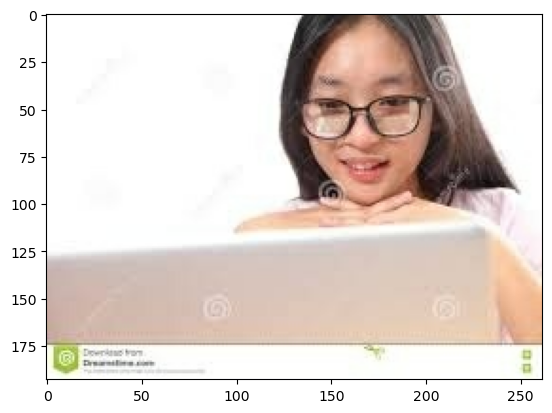

In [7]:
image_path = data_directory + '/train/Image_87.jpg'

image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
plt.imshow(image)

In [8]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

keypoints_with_scores

array([[[[0.3925038 , 0.63268316, 0.58771604],
         [0.3115843 , 0.6959971 , 0.7006744 ],
         [0.31675917, 0.5705619 , 0.72602934],
         [0.3239869 , 0.7777986 , 0.56823426],
         [0.32513043, 0.5180346 , 0.6305187 ],
         [0.5201584 , 0.9124143 , 0.55532104],
         [0.5586628 , 0.42983705, 0.44049537],
         [0.7819881 , 0.9747467 , 0.42526773],
         [0.8482396 , 0.4276199 , 0.11238849],
         [0.74284005, 0.8161833 , 0.07040724],
         [0.7663183 , 0.60522866, 0.15183741],
         [0.84509915, 0.82199466, 0.1281353 ],
         [0.8395629 , 0.5379875 , 0.1653771 ],
         [0.77466434, 0.9169154 , 0.07555535],
         [0.7318136 , 0.34738463, 0.04898756],
         [0.77998364, 0.6696001 , 0.11260153],
         [0.81061834, 0.59120154, 0.17633088]]]], dtype=float32)

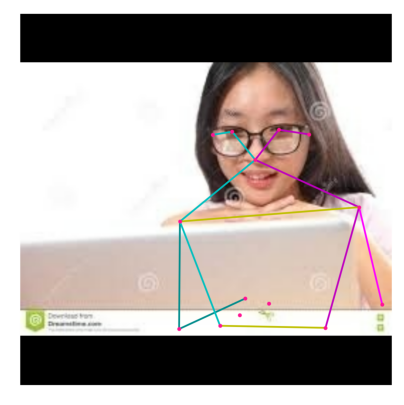

In [9]:
# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

### Batch Process
Load dataframe with training images

In [10]:
df = pd.read_csv(data_directory+'/Training_set.csv')

testdf = df.head(10)
testdf

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
5,Image_6.jpg,sleeping
6,Image_7.jpg,drinking
7,Image_8.jpg,hugging
8,Image_9.jpg,clapping
9,Image_10.jpg,dancing


convert labels from text to numerical

In [11]:
df['label'] = df['label'].astype('category')
df['category'] = df['label'].cat.codes
testdf = df.head(10)
testdf

,filename,label,category
0,Image_1.jpg,sitting,11
1,Image_2.jpg,using_laptop,14
2,Image_3.jpg,hugging,7
3,Image_4.jpg,sleeping,12
4,Image_5.jpg,using_laptop,14
5,Image_6.jpg,sleeping,12
6,Image_7.jpg,drinking,4
7,Image_8.jpg,hugging,7
8,Image_9.jpg,clapping,1
9,Image_10.jpg,dancing,3


define a function that takes as input the image path and returns the image with the keypoints and the category

In [12]:
def image_keypoints(image_path, norm = True):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image).reshape(17,3)
    
    if norm:
        norm_factor_x = np.percentile(keypoints_with_scores[:, 0], 95) - np.percentile(keypoints_with_scores[:, 0], 5)
        norm_factor_y = np.percentile(keypoints_with_scores[:, 1], 95) - np.percentile(keypoints_with_scores[:, 1], 5)

        keypoints_with_scores[:, 0] = (keypoints_with_scores[:, 0] - np.percentile(keypoints_with_scores[:, 0], 5)) / norm_factor_x
        keypoints_with_scores[:, 1] = (keypoints_with_scores[:, 1] - np.percentile(keypoints_with_scores[:, 1], 5)) / norm_factor_y

    return keypoints_with_scores

Process the whole dataframe at once

In [13]:
def keypoints_from_df(df, data_directory):
    
    keypoints = np.zeros((len(df),17,3))
    
    for i, file in enumerate(df['filename']):
        keypoints[i,:,:] = image_keypoints(data_directory + '/train/' + file)
        
    return keypoints

In [14]:
def add_kpoints_dataframe(df, data_directory):
    
    df = df.astype('object')
    df['keypoints'] = np.zeros((len(df),51)).tolist()

    kds = keypoints_from_df(df, data_directory).reshape(-1, 51).tolist()
    df['keypoints'] = kds

    return df

Compute keypoints for the whole dataframe

In [15]:
# add_points_dataframe(df, data_directory)

In [16]:
testdf = add_kpoints_dataframe(testdf, data_directory)
testdf

,filename,label,category,keypoints
0,Image_1.jpg,sitting,11,"[0.061675380915403366, 0.5088022351264954, 0.3..."
1,Image_2.jpg,using_laptop,14,"[0.21077553927898407, 0.9952505230903625, 0.70..."
2,Image_3.jpg,hugging,7,"[0.09106560796499252, 0.4751551151275635, 0.56..."
3,Image_4.jpg,sleeping,12,"[0.2707705795764923, 0.4170026183128357, 0.304..."
4,Image_5.jpg,using_laptop,14,"[0.02712867222726345, 0.23545879125595093, 0.7..."
5,Image_6.jpg,sleeping,12,"[0.6235983967781067, 0.12945030629634857, 0.36..."
6,Image_7.jpg,drinking,4,"[0.07875850051641464, 0.6276645064353943, 0.71..."
7,Image_8.jpg,hugging,7,"[0.08418595790863037, 0.674087405204773, 0.508..."
8,Image_9.jpg,clapping,1,"[0.04615618288516998, 0.3501565456390381, 0.70..."
9,Image_10.jpg,dancing,3,"[0.7625035047531128, 0.7993135452270508, 0.106..."


## MobileNet, object recognition

In [56]:
if mobilenet_name == "mobilenet_large":
    print("Loading MobileNetV3Large")
    mobile_net = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_preprocessing=True)
    print("Loading Complete")

elif mobilenet_name == "mobilenet_small":
    print("Loading MobileNetV3Small")
    mobile_net = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_preprocessing=True)
    print("Loading Complete")

else:
    print("Invalid Name")

Loading MobileNetV3Large


Loading Complete


#### Single image example

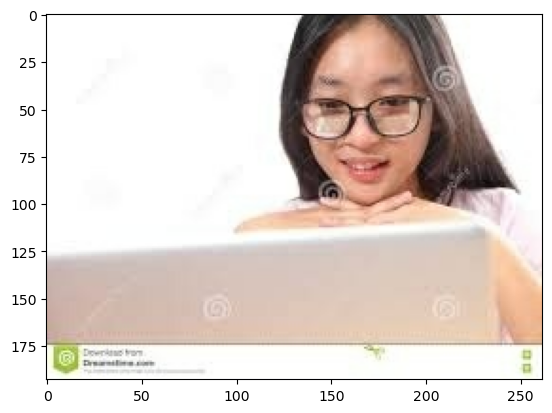

In [18]:
image_path = data_directory + '/train/Image_87.jpg'

image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
plt.imshow(image)

In [19]:
def load_prepare_image(image_path, expand_dims=True):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    if expand_dims:
        img = np.expand_dims(img, axis=0)  
    
    return img

Use MoveNet to predict the objects in the image

In [20]:
obj_pred = mobile_net.predict(load_prepare_image(image_path))
obj_pred.shape

1/1 [==============================] - 1s 596ms/step


(1, 1000)

Print top predictions along with scores

In [21]:
for desc in decode_predictions(obj_pred)[0]:
    print(desc)

('n03832673', 'notebook', 0.3208648)
('n03642806', 'laptop', 0.2063966)
('n06359193', 'web_site', 0.07198304)
('n03485407', 'hand-held_computer', 0.06084741)
('n04009552', 'projector', 0.025987137)


### Batch Process

In [22]:
def object_rec(df, data_directory):
    images = df['filename']
    obj_list = []
    
    for i, image in enumerate(images):
        image_path = data_directory + '/train/' + image
         
        obj_pred = mobile_net.predict(load_prepare_image(image_path), verbose=0)
        obj_list.append(obj_pred)

    df['object'] = np.zeros((len(df), 1000)).tolist()    
    df['object'] = obj_list
    
    df['obj_label'] = df['object'].apply(lambda x: np.argsort(x[0])[::-1][:5])
    df['object'] = df['object'].apply(lambda x: np.sort(x[0])[::-1][:5])
    
    return df

In [23]:
testdf = object_rec(testdf, data_directory)

In [24]:
testdf

,filename,label,category,keypoints,object,obj_label
0,Image_1.jpg,sitting,11,"[0.061675380915403366, 0.5088022351264954, 0.3...","[0.6048032, 0.04718748, 0.032203395, 0.0221246...","[697, 789, 822, 514, 614]"
1,Image_2.jpg,using_laptop,14,"[0.21077553927898407, 0.9952505230903625, 0.70...","[0.7418778, 0.040941067, 0.0128924195, 0.00857...","[831, 416, 669, 697, 681]"
2,Image_3.jpg,hugging,7,"[0.09106560796499252, 0.4751551151275635, 0.56...","[0.14159973, 0.1360461, 0.054539572, 0.0444455...","[697, 522, 984, 529, 416]"
3,Image_4.jpg,sleeping,12,"[0.2707705795764923, 0.4170026183128357, 0.304...","[0.6505078, 0.06191684, 0.027491065, 0.0246346...","[678, 691, 680, 529, 823]"
4,Image_5.jpg,using_laptop,14,"[0.02712867222726345, 0.23545879125595093, 0.7...","[0.71057403, 0.10088834, 0.035408285, 0.016313...","[490, 655, 689, 824, 601]"
5,Image_6.jpg,sleeping,12,"[0.6235983967781067, 0.12945030629634857, 0.36...","[0.4215644, 0.07435702, 0.035931338, 0.0312456...","[529, 797, 639, 680, 830]"
6,Image_7.jpg,drinking,4,"[0.07875850051641464, 0.6276645064353943, 0.71...","[0.12104209, 0.10682879, 0.063497074, 0.062168...","[906, 681, 620, 916, 851]"
7,Image_8.jpg,hugging,7,"[0.08418595790863037, 0.674087405204773, 0.508...","[0.20102724, 0.11554531, 0.039009392, 0.032306...","[487, 678, 906, 743, 903]"
8,Image_9.jpg,clapping,1,"[0.04615618288516998, 0.3501565456390381, 0.70...","[0.2865237, 0.07932686, 0.076078214, 0.0534756...","[487, 818, 503, 834, 731]"
9,Image_10.jpg,dancing,3,"[0.7625035047531128, 0.7993135452270508, 0.106...","[0.67292166, 0.06629763, 0.03567065, 0.0260543...","[400, 667, 399, 854, 743]"


## Word Vectorization

In [25]:
word_vec_model = "glove-wiki-gigaword-100"

In [26]:
vectorize_label = gensim.downloader.load(word_vec_model) 

In [27]:
objects_vocabulary = []
with open(root_directory + '/mobilenet_dic.txt', 'r') as f:
    for line in f:
        objects_vocabulary.append(line.replace('-', ' ').replace("'s","").strip().split(','))

In [28]:
objects_vocabulary

[['background'],
 ['tench', ' Tinca tinca'],
 ['goldfish', ' Carassius auratus'],
 ['great white shark',
  ' white shark',
  ' man eater',
  ' man eating shark',
  ' Carcharodon carcharias'],
 ['tiger shark', ' Galeocerdo cuvieri'],
 ['hammerhead', ' hammerhead shark'],
 ['electric ray', ' crampfish', ' numbfish', ' torpedo'],
 ['stingray'],
 ['cock'],
 ['hen'],
 ['ostrich', ' Struthio camelus'],
 ['brambling', ' Fringilla montifringilla'],
 ['goldfinch', ' Carduelis carduelis'],
 ['house finch', ' linnet', ' Carpodacus mexicanus'],
 ['junco', ' snowbird'],
 ['indigo bunting', ' indigo finch', ' indigo bird', ' Passerina cyanea'],
 ['robin', ' American robin', ' Turdus migratorius'],
 ['bulbul'],
 ['jay'],
 ['magpie'],
 ['chickadee'],
 ['water ouzel', ' dipper'],
 ['kite'],
 ['bald eagle', ' American eagle', ' Haliaeetus leucocephalus'],
 ['vulture'],
 ['great grey owl', ' great gray owl', ' Strix nebulosa'],
 ['European fire salamander', ' Salamandra salamandra'],
 ['common newt', ' T

In [29]:
cleaned_vocabulary = []

for alias in objects_vocabulary:
    
    # Step 1 - Keep only the first alias
    alias = alias[0]
    
    # Step 2 - Basic preprocessing (lowercase, remove whitespaces, )
    alias = alias.lower().strip().split()
    
    cleaned_vocabulary.append(alias)
    
    
cleaned_vocabulary

[['background'],
 ['tench'],
 ['goldfish'],
 ['great', 'white', 'shark'],
 ['tiger', 'shark'],
 ['hammerhead'],
 ['electric', 'ray'],
 ['stingray'],
 ['cock'],
 ['hen'],
 ['ostrich'],
 ['brambling'],
 ['goldfinch'],
 ['house', 'finch'],
 ['junco'],
 ['indigo', 'bunting'],
 ['robin'],
 ['bulbul'],
 ['jay'],
 ['magpie'],
 ['chickadee'],
 ['water', 'ouzel'],
 ['kite'],
 ['bald', 'eagle'],
 ['vulture'],
 ['great', 'grey', 'owl'],
 ['european', 'fire', 'salamander'],
 ['common', 'newt'],
 ['eft'],
 ['spotted', 'salamander'],
 ['axolotl'],
 ['bullfrog'],
 ['tree', 'frog'],
 ['tailed', 'frog'],
 ['loggerhead'],
 ['leatherback', 'turtle'],
 ['mud', 'turtle'],
 ['terrapin'],
 ['box', 'turtle'],
 ['banded', 'gecko'],
 ['common', 'iguana'],
 ['american', 'chameleon'],
 ['whiptail'],
 ['agama'],
 ['frilled', 'lizard'],
 ['alligator', 'lizard'],
 ['gila', 'monster'],
 ['green', 'lizard'],
 ['african', 'chameleon'],
 ['komodo', 'dragon'],
 ['african', 'crocodile'],
 ['american', 'alligator'],
 ['tri

Introducing Word Ninja
It splits composite words into basic words -> ex. "ashtray" -> "ash" + "tray"

In [30]:
def label_to_vector(vocabulary):
    
    word_vectors = []
    
    standard = 0
    wninja = 0
    
    for word in vocabulary:
        #rint(word)
        try:
            word_vectors.append(np.sum([vectorize_label[wi]for wi in word], axis=0))
            standard += 1
        except:
            word = ([wordninja.split(w) for w in word])[0]
            word = [w for w in word if len(w)>2]
            try:
                word_vectors.append(np.sum([vectorize_label[wi]for wi in word], axis=0))
                wninja += 1
            except:
                print(word)
                word_vectors.append(np.zeros(100))
    
    print("Vectorized normally: " , standard , '\n', 'Vectorized with wordninja: ', wninja, '\n', "Not vectorized: ", len(vocabulary)-standard-wninja)
    
    return word_vectors

In [31]:
vector_words_list = label_to_vector(cleaned_vocabulary)

['keeshond']
['jinrikisha']
['saltshaker']
Vectorized normally:  975 
 Vectorized with wordninja:  23 
 Not vectorized:  3


In [32]:
def add_vectors_dataframe(df):
    df['obj_vector'] = df['obj_label'].apply(lambda x: [vector_words_list[i+1].tolist() for i in x])
    df['obj_words'] = df['obj_label'].apply(lambda x: [cleaned_vocabulary[i+1] for i in x])

In [33]:
add_vectors_dataframe(testdf)

In [34]:
testdf

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,sitting,11,"[0.061675380915403366, 0.5088022351264954, 0.3...","[0.6048032, 0.04718748, 0.032203395, 0.0221246...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo..."
1,Image_2.jpg,using_laptop,14,"[0.21077553927898407, 0.9952505230903625, 0.70...","[0.7418778, 0.040941067, 0.0128924195, 0.00857...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ..."
2,Image_3.jpg,hugging,7,"[0.09106560796499252, 0.4751551151275635, 0.56...","[0.14159973, 0.1360461, 0.054539572, 0.0444455...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape..."
3,Image_4.jpg,sleeping,12,"[0.2707705795764923, 0.4170026183128357, 0.304...","[0.6505078, 0.06191684, 0.027491065, 0.0246346...","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia..."
4,Image_5.jpg,using_laptop,14,"[0.02712867222726345, 0.23545879125595093, 0.7...","[0.71057403, 0.10088834, 0.035408285, 0.016313...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto..."
5,Image_6.jpg,sleeping,12,"[0.6235983967781067, 0.12945030629634857, 0.36...","[0.4215644, 0.07435702, 0.035931338, 0.0312456...","[529, 797, 639, 680, 830]","[[-0.3597100079059601, 0.323419988155365, -0.0...","[[diaper], [sleeping, bag], [maillot], [nipple..."
6,Image_7.jpg,drinking,4,"[0.07875850051641464, 0.6276645064353943, 0.71...","[0.12104209, 0.10682879, 0.063497074, 0.062168...","[906, 681, 620, 916, 851]","[[-0.4260779917240143, -0.6597400307655334, 0....","[[windsor, tie], [notebook], [laptop], [web, s..."
7,Image_8.jpg,hugging,7,"[0.08418595790863037, 0.674087405204773, 0.508...","[0.20102724, 0.11554531, 0.039009392, 0.032306...","[487, 678, 906, 743, 903]","[[0.3064900040626526, -1.0355499982833862, 0.5...","[[cellular, telephone], [neck, brace], [windso..."
8,Image_9.jpg,clapping,1,"[0.04615618288516998, 0.3501565456390381, 0.70...","[0.2865237, 0.07932686, 0.076078214, 0.0534756...","[487, 818, 503, 834, 731]","[[0.3064900040626526, -1.0355499982833862, 0.5...","[[cellular, telephone], [spotlight], [cocktail..."
9,Image_10.jpg,dancing,3,"[0.7625035047531128, 0.7993135452270508, 0.106...","[0.67292166, 0.06629763, 0.03567065, 0.0260543...","[400, 667, 399, 854, 743]","[[-0.11419299989938736, 0.857990026473999, -1....","[[academic, gown], [mortarboard], [abaya], [th..."


## Final Preprocessing and write dataframe

In [38]:
def complete_preprocessing(df, data_directory, file_name = None, write=True):
    
    start = time.time()
    
    df = add_kpoints_dataframe(df, data_directory)
    df = object_rec(df, data_directory)
    add_vectors_dataframe(df)
    
    end = time.time()
    
    print("Processing time:", round(end-start,2), ' s')
    print("Avg time per row:", round((end-start)/len(df),3), ' s')
    
    if write:
        if file_name:
            print("Saving as: ", str(data_directory + '/' + file_name + '.pkl'))
            df.to_pickle(data_directory + '/' + file_name + '.pkl')
        
        else:
            print("Saving with default name ", str(data_directory + '/' + fname + '.pkl'))
            df.to_pickle(data_directory + '/' + fname + '.pkl')
    else:
        print("Not saving dataframe")
            
    return df
    

In [57]:
complete_preprocessing(df.head(1000), data_directory, write=False)

Processing time: 64.7  s
Avg time per row: 0.065  s
Not saving dataframe


,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,sitting,11,"[0.061675380915403366, 0.5088022351264954, 0.3...","[0.6048032, 0.04718748, 0.032203395, 0.0221246...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo..."
1,Image_2.jpg,using_laptop,14,"[0.21077553927898407, 0.9952505230903625, 0.70...","[0.7418778, 0.040941067, 0.0128924195, 0.00857...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ..."
2,Image_3.jpg,hugging,7,"[0.09106560796499252, 0.4751551151275635, 0.56...","[0.14159973, 0.1360461, 0.054539572, 0.0444455...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape..."
3,Image_4.jpg,sleeping,12,"[0.2707705795764923, 0.4170026183128357, 0.304...","[0.6505078, 0.06191684, 0.027491065, 0.0246346...","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia..."
4,Image_5.jpg,using_laptop,14,"[0.02712867222726345, 0.23545879125595093, 0.7...","[0.71057403, 0.10088834, 0.035408285, 0.016313...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto..."
...,...,...,...,...,...,...,...,...
995,Image_996.jpg,using_laptop,14,"[0.03744707629084587, 0.37654048204421997, 0.5...","[0.1329601, 0.08874232, 0.05478846, 0.03776383...","[499, 792, 514, 879, 796]","[[0.12297999858856201, -0.34841999411582947, -...","[[cleaver], [shovel], [cowboy, boot], [umbrell..."
996,Image_997.jpg,fighting,6,"[0.014242276549339294, 0.1785597801208496, 0.3...","[0.2908797, 0.05785669, 0.05456648, 0.02401797...","[912, 981, 489, 429, 752]","[[-0.7849909663200378, -0.3131999969482422, 0....","[[worm, fence], [ballplayer], [chainlink, fenc..."
997,Image_998.jpg,texting,13,"[0.09668418020009995, 0.5404313802719116, 0.64...","[0.081566334, 0.06668637, 0.050425008, 0.03815...","[739, 416, 608, 610, 929]","[[-0.4219299852848053, -0.378570020198822, 0.3...","[[potter, wheel], [balance, beam], [jean], [je..."
998,Image_999.jpg,cycling,2,"[0.10942919552326202, 0.9943938255310059, 0.63...","[0.49869734, 0.27055624, 0.04587965, 0.0065906...","[671, 444, 880, 870, 638]","[[-0.08019000291824341, 0.579479992389679, 0.6...","[[mountain, bike], [bicycle, built, for, two],..."


In [58]:
#file_name = 'test_head_df'

finaltest = complete_preprocessing(df.head(10), data_directory)
finaltest

Processing time: 0.83  s
Avg time per row: 0.08  s
Saving with default name  /Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition/movenet_lightning_mobilenet_large.pkl


,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,sitting,11,"[0.061675380915403366, 0.5088022351264954, 0.3...","[0.6048032, 0.04718748, 0.032203395, 0.0221246...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo..."
1,Image_2.jpg,using_laptop,14,"[0.21077553927898407, 0.9952505230903625, 0.70...","[0.7418778, 0.040941067, 0.0128924195, 0.00857...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ..."
2,Image_3.jpg,hugging,7,"[0.09106560796499252, 0.4751551151275635, 0.56...","[0.14159973, 0.1360461, 0.054539572, 0.0444455...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape..."
3,Image_4.jpg,sleeping,12,"[0.2707705795764923, 0.4170026183128357, 0.304...","[0.6505078, 0.06191684, 0.027491065, 0.0246346...","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia..."
4,Image_5.jpg,using_laptop,14,"[0.02712867222726345, 0.23545879125595093, 0.7...","[0.71057403, 0.10088834, 0.035408285, 0.016313...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto..."
5,Image_6.jpg,sleeping,12,"[0.6235983967781067, 0.12945030629634857, 0.36...","[0.4215644, 0.07435702, 0.035931338, 0.0312456...","[529, 797, 639, 680, 830]","[[-0.3597100079059601, 0.323419988155365, -0.0...","[[diaper], [sleeping, bag], [maillot], [nipple..."
6,Image_7.jpg,drinking,4,"[0.07875850051641464, 0.6276645064353943, 0.71...","[0.12104209, 0.10682879, 0.063497074, 0.062168...","[906, 681, 620, 916, 851]","[[-0.4260779917240143, -0.6597400307655334, 0....","[[windsor, tie], [notebook], [laptop], [web, s..."
7,Image_8.jpg,hugging,7,"[0.08418595790863037, 0.674087405204773, 0.508...","[0.20102724, 0.11554531, 0.039009392, 0.032306...","[487, 678, 906, 743, 903]","[[0.3064900040626526, -1.0355499982833862, 0.5...","[[cellular, telephone], [neck, brace], [windso..."
8,Image_9.jpg,clapping,1,"[0.04615618288516998, 0.3501565456390381, 0.70...","[0.2865237, 0.07932686, 0.076078214, 0.0534756...","[487, 818, 503, 834, 731]","[[0.3064900040626526, -1.0355499982833862, 0.5...","[[cellular, telephone], [spotlight], [cocktail..."
9,Image_10.jpg,dancing,3,"[0.7625035047531128, 0.7993135452270508, 0.106...","[0.67292166, 0.06629763, 0.03567065, 0.0260543...","[400, 667, 399, 854, 743]","[[-0.11419299989938736, 0.857990026473999, -1....","[[academic, gown], [mortarboard], [abaya], [th..."


In [47]:
loaded_df = pd.read_pickle(data_directory + "/" + fname + '.pkl')
loaded_df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,sitting,11,"[0.061675380915403366, 0.5088022351264954, 0.3...","[0.6048032, 0.04718748, 0.032203395, 0.0221246...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo..."
1,Image_2.jpg,using_laptop,14,"[0.21077553927898407, 0.9952505230903625, 0.70...","[0.7418778, 0.040941067, 0.0128924195, 0.00857...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ..."
2,Image_3.jpg,hugging,7,"[0.09106560796499252, 0.4751551151275635, 0.56...","[0.14159973, 0.1360461, 0.054539572, 0.0444455...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape..."
3,Image_4.jpg,sleeping,12,"[0.2707705795764923, 0.4170026183128357, 0.304...","[0.6505078, 0.06191684, 0.027491065, 0.0246346...","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia..."
4,Image_5.jpg,using_laptop,14,"[0.02712867222726345, 0.23545879125595093, 0.7...","[0.71057403, 0.10088834, 0.035408285, 0.016313...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto..."
5,Image_6.jpg,sleeping,12,"[0.6235983967781067, 0.12945030629634857, 0.36...","[0.4215644, 0.07435702, 0.035931338, 0.0312456...","[529, 797, 639, 680, 830]","[[-0.3597100079059601, 0.323419988155365, -0.0...","[[diaper], [sleeping, bag], [maillot], [nipple..."
6,Image_7.jpg,drinking,4,"[0.07875850051641464, 0.6276645064353943, 0.71...","[0.12104209, 0.10682879, 0.063497074, 0.062168...","[906, 681, 620, 916, 851]","[[-0.4260779917240143, -0.6597400307655334, 0....","[[windsor, tie], [notebook], [laptop], [web, s..."
7,Image_8.jpg,hugging,7,"[0.08418595790863037, 0.674087405204773, 0.508...","[0.20102724, 0.11554531, 0.039009392, 0.032306...","[487, 678, 906, 743, 903]","[[0.3064900040626526, -1.0355499982833862, 0.5...","[[cellular, telephone], [neck, brace], [windso..."
8,Image_9.jpg,clapping,1,"[0.04615618288516998, 0.3501565456390381, 0.70...","[0.2865237, 0.07932686, 0.076078214, 0.0534756...","[487, 818, 503, 834, 731]","[[0.3064900040626526, -1.0355499982833862, 0.5...","[[cellular, telephone], [spotlight], [cocktail..."
9,Image_10.jpg,dancing,3,"[0.7625035047531128, 0.7993135452270508, 0.106...","[0.67292166, 0.06629763, 0.03567065, 0.0260543...","[400, 667, 399, 854, 743]","[[-0.11419299989938736, 0.857990026473999, -1....","[[academic, gown], [mortarboard], [abaya], [th..."


In [ ]:
def complete_preprocessing(df, data_directory, file_name = None, write=True):
    
    start = time.time()
    
    df = add_kpoints_dataframe(df, data_directory)
    df = object_rec(df, data_directory)
    add_vectors_dataframe(df)
    
    end = time.time()
    
    print("Processing time:", round(end-start,2), ' s')
    print("Avg time per row:", round((end-start)/len(df),2), ' s')
    
    if write:
        if file_name:
            print("Saving as: ", str(data_directory + '/' + file_name + '.pkl'))
            df.to_pickle(data_directory + '/' + file_name + '.pkl')
        
        else:
            print("Saving with default name ", str(data_directory + '/' + fname + '.pkl'))
            df.to_pickle(data_directory + '/' + fname + '.pkl')
    else:
        print("Not saving dataframe")
            
    return df